Felipe Faustino Brito

2021007366

# Questão 1

##### Montando o Filtro Passa Faixa para 100 Hz e 180 Hz

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import control as ctl
import control.matlab as cnt
pi = np.pi

In [2]:
def get_signal(components: dict[float, float], frequency: float, time=None) -> tuple[np.ndarray, np.ndarray]:
    """
        Gera um sinal composto por várias componentes senoidais.
        
        Params:
            components (dict[float, float]): Um dicionário onde as chaves são as frequências (em Hz) e os valores são as amplitudes das componentes senoidais.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            time (np.ndarray, opcional): Um array de tempos. Se não for fornecido, será gerado automaticamente com base na frequência de amostragem.
        Returns:
            tuple[np.ndarray, np.ndarray]: Uma tupla contendo o sinal gerado e o array de tempos.
    """

    if time is None:
        time = np.arange(0, 2, 1/frequency)
    signal_data = np.zeros_like(time)
    for freq, amp in components.items():
        signal_data += amp * np.sin(2 * np.pi * freq * time)

    return signal_data, time

In [3]:
def plot_signal(signal: np.ndarray, time: np.ndarray, frequency: float, limite=800):
    """
        Plota um sinal no domínio do tempo e sua resposta em frequência.
        
        Params:
            signal (np.ndarray): O sinal a ser plotado.
            time (np.ndarray): O array de tempos correspondente ao sinal.
            frequency (float): A frequência de amostragem do sinal (em Hz).
            limite (float, opcional): O limite superior do eixo x da resposta em frequência.
    """
    # Plotar o sinal no domínio do tempo
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title('Sinal composto')
    plt.xlabel('Tempo [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

    # Resposta em frequência (FFT)
    frequencia_fft = np.fft.fftfreq(len(signal), 1/frequency)
    espectro_fft = np.fft.fft(signal)

    # Plotar a magnitude da resposta em frequência
    plt.figure(figsize=(10, 4))
    plt.plot(frequencia_fft[:len(frequencia_fft)//2], np.abs(espectro_fft)[:len(espectro_fft)//2])
    plt.title('Resposta em frequência do sinal')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.xlim(0, limite)
    plt.show()

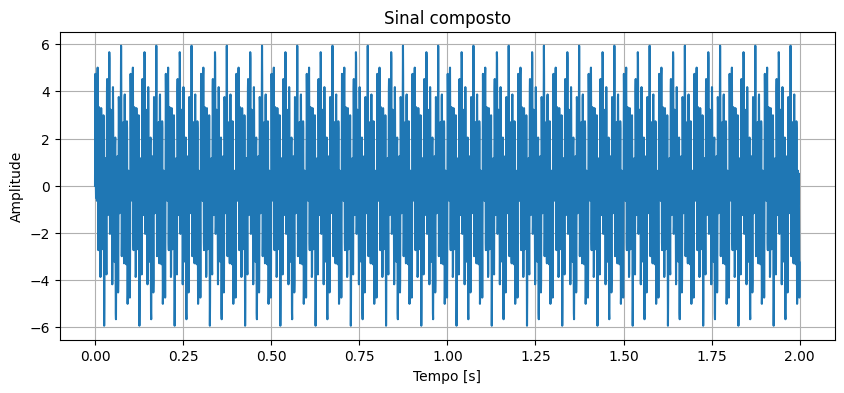

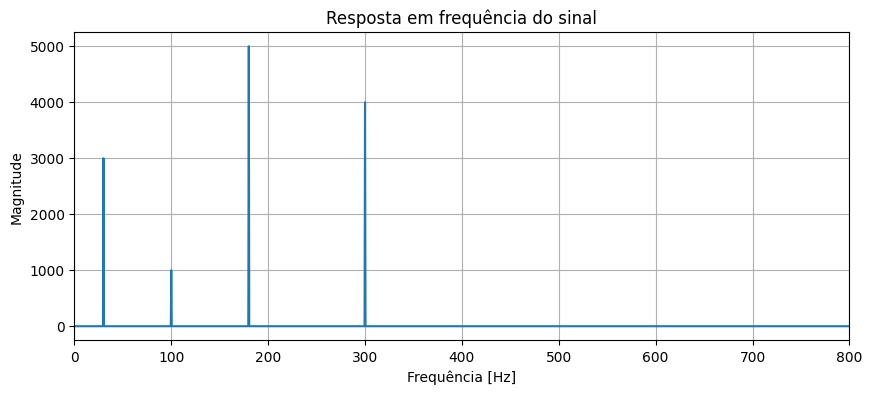

In [4]:
fs = 2000

components = {
    30: 1.5,   
    100: 0.5,  
    180: 2.5, 
    300: 2.0 
}

signal_data, time = get_signal(components=components, frequency=fs)

plot_signal(signal=signal_data, time=time, frequency=fs)

In [5]:
def get_Hs_filter(Wp: float, Ws: float, Rp: float, Rs: float, filter_type: str = 'passa-baixa'):
    """
    Calcula a função de transferência em tempo contínuo de um filtro Butterworth passa-alta ou passa-baixa.
    
    Params:
        Wp (float): Frequência de corte na faixa de passagem (em rad/s).
        Ws (float): Frequência de corte na faixa de rejeição (em rad/s).
        Rp (float): Ripple na faixa de passagem (em dB).
        Rs (float): Ripple na faixa de rejeição (em dB).
        filter_type (str): Tipo de filtro (passa-baixa ou passa-alta).
    Returns:
        Hs (control.TransferFunction): Função de transferência em tempo contínuo do filtro.
    """

    # 2) Cálculo da Ordem do Filtro e sua Frequência de Corte:
    #calcular a frequência de corte com a ordem negativa
    N = np.log10((1/Rp**2 - 1)/(1/Rs**2 - 1)) / (2*np.log10(Wp/Ws))
    # print('\n', N)
    N = int(np.sign(N)*np.ceil(abs(N)))
    # print('\nN = ', N)
    Wc = Wp*(1/(1/Rp**2 - 1))**(1/(2*N))
    print('Wc = ',Wc,'rad/s')
    print('fc = ',Wc/(2*pi),'Hz')

    # 3) Cálculo dos polos do filtro:
    # para o restante do procedimento, usar a ordem com sinal positivo.
    if N<0:
        N = -N
    print('\nN = ',N)
    k = np.arange(0,2*N)
    polos = Wc*np.exp((1j*pi/(2*N))*(2*k+N-1))
    # print('\nTodos os polos: ',polos)
    polosEst = [p for p in polos if np.real(p)<0]
    # print('Polos estáveis: ',polosEst)
    # 4) Montar a função de transferência contínua:
    #no numerador, usa-se s**N no lugar de Wc**N
    if filter_type == 'passa-alta':
        numS = np.append(1,np.zeros(N))
    else:
        numS = Wc**N
    denS = np.poly(polosEst)
    Hs = ctl.tf(numS,denS)
    print('H(s):',Hs)
    return Hs

In [6]:
def get_Hz_filter(Hs: ctl.TransferFunction, frequency: float, method: str = 'bilinear') -> ctl.TransferFunction:
    """
        Converte uma função de transferência em tempo contínuo para tempo discreto.

        Params:
            Hs (control.TransferFunction): Função de transferência em tempo contínuo.
            frequency (float): Frequência de amostragem (em Hz).
            method (str): Método de discretização ('bilinear' ou 'tustin').
        Returns:
            Hz (control.TransferFunction): Função de transferência em tempo discreto.
    """
    Ts = 1/frequency
    Hz = ctl.c2d(Hs,Ts,method)
    print('H(z):',Hz)
    return Hz

In [7]:
def plot_Hz(Hz: ctl.TransferFunction, frequency: float):
    numZ = Hz.num[0][0]
    denZ = Hz.den[0][0]
    w,h = signal.freqz(numZ,denZ,worN=1000,fs=frequency)
    fig2 = plt.figure(2)
    fig2.clf()
    ax0 = fig2.add_subplot(211)
    ax0.plot(w,20*np.log10(abs(h)))
    ax0.grid(True)
    ax1 = fig2.add_subplot(212)
    ax1.plot(w,np.angle(h)*180/np.pi)
    ax1.grid(True)
    plt.show()

In [8]:
def plot_transfer_functions(transfer_functions: list[ctl.TransferFunction], legend: list[str]=None):
    """
    Plota o diagrama de Bode de uma ou mais funções de transferência.

    Params:
        transfer_functions (list[control.TransferFunction]): Lista de funções de transferência.
        legend (list[str], opcional): Lista de legendas para as funções de transferência.
    """
    plt.figure(1)
    plt.clf()
    for tf in transfer_functions:
        ctl.bode(tf,dB=True,Hz=True)
    if legend:
        plt.legend(legend)
    plt.show()

In [9]:
# Parametros do Passa-Alta
Wp_1 = 2*pi*80
Ws_1 = 2*pi*45

# Parametros do Passa-Baixa
Wp_2 = 2*pi*220
Ws_2 = 2*pi*280   

# Ripple na faixa de passagem e rejeição
Rp = 0.70
Rs = 0.25


Hs_passa_alta = get_Hs_filter(Wp_1, Ws_1, Rp, Rs, filter_type='passa-alta')

Wc =  506.0175016104112 rad/s
fc =  80.53518667230806 Hz

N =  3
H(s): <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                  s^3
----------------------------------------
s^3 + 1012 s^2 + 5.121e+05 s + 1.296e+08



In [10]:
Hs_passa_baixa = get_Hs_filter(Wp_2, Ws_2, Rp, Rs, filter_type='passa-baixa')

Wc =  1377.7001568190242 rad/s
fc =  219.26779005622708 Hz

N =  6
H(s): <TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                       6.838e+18
---------------------------------------------------------------------------------------
s^6 + 5323 s^5 + 1.417e+07 s^4 + 2.39e+10 s^3 + 2.689e+13 s^2 + 1.918e+16 s + 6.838e+18



c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


0 states have been removed from the model

Passa-faixa:
Hpf(s): <TransferFunction>: sys[5]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                                                            6.838e+18 s^3
--------------------------------------------------------------------------------------------------------------------------------------
s^9 + 6335 s^8 + 2.007e+07 s^7 + 4.11e+10 s^6 + 5.903e+13 s^5 + 6.047e+16 s^4 + 4.311e+19 s^3 + 2.023e+22 s^2 + 5.986e+24 s + 8.86e+26



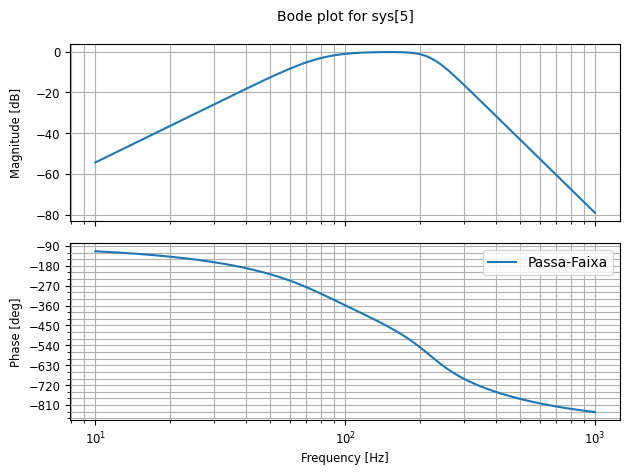

In [12]:
Hs_passa_faixa = ctl.minreal(Hs_passa_baixa * Hs_passa_alta)


print('\nPassa-faixa:')
print('Hpf(s):', Hs_passa_faixa)

plot_transfer_functions([Hs_passa_faixa], legend=['Passa-Faixa'])

H(z): <TransferFunction>: sys[5]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.0003491 z^9 + 0.001047 z^8 + 4.277e-14 z^7 - 0.002793 z^6 - 0.002095 z^5 + 0.002095 z^4 + 0.002793 z^3 - 2.576e-14 z^2 - 0.001047 z - 0.0003491
-------------------------------------------------------------------------------------------------------------------------------------------------
                  z^9 - 5.943 z^8 + 16.01 z^7 - 25.64 z^6 + 26.86 z^5 - 19.05 z^4 + 9.142 z^3 - 2.858 z^2 + 0.5273 z - 0.04374

dt = 0.0005



c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:461: LinAlgWarning: Ill-conditioned matrix (rcond=9.74387e-47): result may not be accurate.
  ad = linalg.solve(ima, np.eye(a.shape[0]) + (1.0-alpha)*dt*a)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:462: LinAlgWarning: Ill-conditioned matrix (rcond=9.74387e-47): result may not be accurate.
  bd = linalg.solve(ima, dt*b)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\scipy\signal\_lti_conversion.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.61308e-47): result may not be accurate.
  cd = linalg.solve(ima.transpose(), c.transpose())


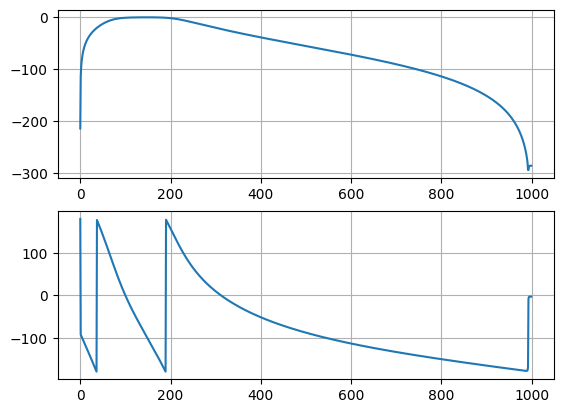

In [13]:
Hz_passa_faixa = get_Hz_filter(Hs_passa_faixa, fs)
plot_Hz(Hz_passa_faixa, fs)

In [14]:
def filtrar_sinal(Hz, signal_data, t):
    """
    Filtra um sinal utilizando a função de transferência discreta Hz.

    Params:
        Hz: Função de transferência discreta do filtro.
        signal_data: Sinal a ser filtrado.

    Returns:
        numpy.ndarray: Sinal filtrado.
    """

    b = np.reshape(Hz.num, -1)
    a = np.reshape(Hz.den, -1)

    yout = signal.lfilter(b, a, signal_data)

    return yout

Sinal filtrado: [0.00000000e+00+0.00000000e+00j 1.13584396e-03+0.00000000e+00j
 1.18124452e-02+1.95541008e-15j ... 1.84629930e+00-4.19812001e-15j
 1.22490836e+00-5.13869546e-15j 2.59919824e-01-1.04229552e-14j]
sinal:  [ 0.          3.25327194  4.73914526 ... -3.9213159  -4.73914526
 -3.25327194]


c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\felip\AppData\Local\pypoetry\Cache\virtualenvs\digital-signal-processing-_OpJIL78-py3.11\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


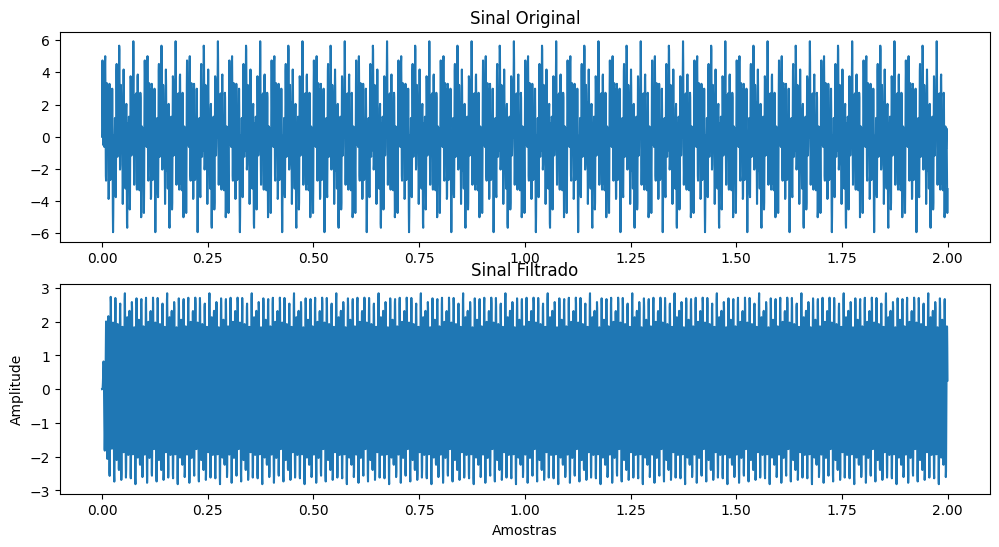

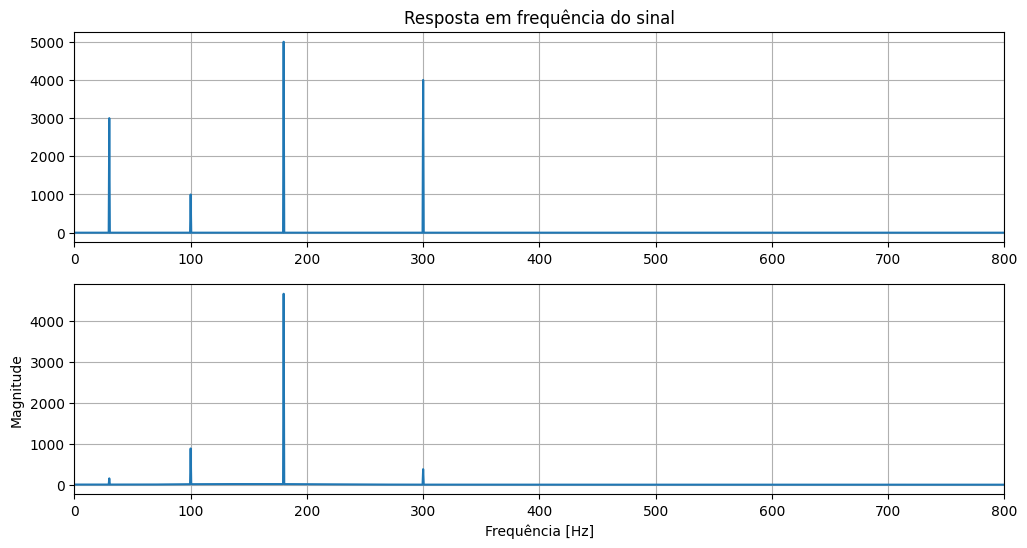

In [15]:
t = np.arange(0, 2, 1/fs)
yout = filtrar_sinal(Hz_passa_faixa, signal_data, t)


print('Sinal filtrado:', yout)
print('sinal: ', signal_data)

# Plot no domínio do tempo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, signal_data)
plt.title('Sinal Original')
plt.subplot(2, 1, 2)
plt.plot(t, yout)
plt.title('Sinal Filtrado')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(signal_data), 1/fs)
espectro = np.fft.fft(signal_data)

frequencia_filtr = np.fft.fftfreq(len(yout), 1/fs)
espectro_filtr = np.fft.fft(yout)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 800)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 800)
plt.show()

Utilizando a Lib Signal para montar o filtro:

H(z): <TransferFunction>: sys[8]$sampled
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.01414 z^8 - 0.1131 z^7 + 0.3961 z^6 - 0.7925 z^5 + 0.9909 z^4 - 0.793 z^3 + 0.3966 z^2 - 0.1134 z + 0.01418
-------------------------------------------------------------------------------------------------------------
        z^8 - 8.003 z^7 + 28.02 z^6 - 56.07 z^5 + 70.12 z^4 - 56.12 z^3 + 28.07 z^2 - 8.024 z + 1.003

dt = 0.0005



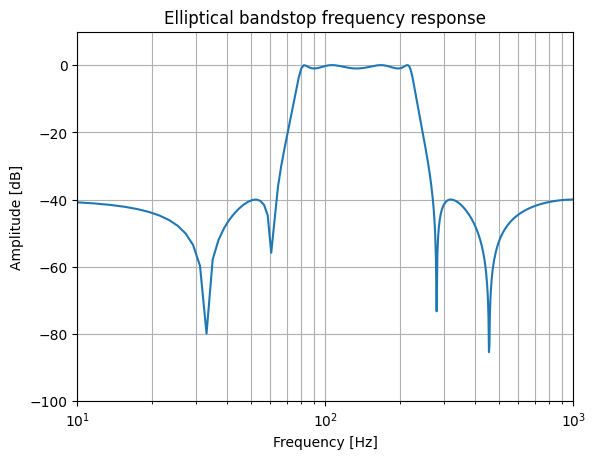

In [16]:
wp = [80, 220]
ws = [45, 280]
gpass = 1
gstop = 40


b, a = signal.iirdesign(wp, ws, gpass, gstop, fs=fs, output='ba', ftype='ellip')
w, h = signal.freqz(b, a, fs=fs)

Hs = ctl.tf(b, a)
ts = 1/fs
Hz = ctl.c2d(Hs, ts, 'bilinear')
print('H(z):', Hz)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('Elliptical bandstop frequency response')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

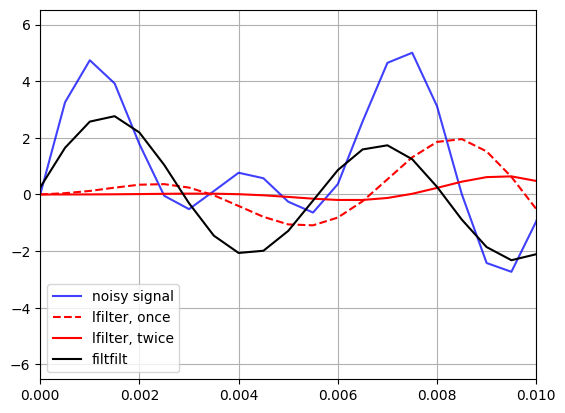

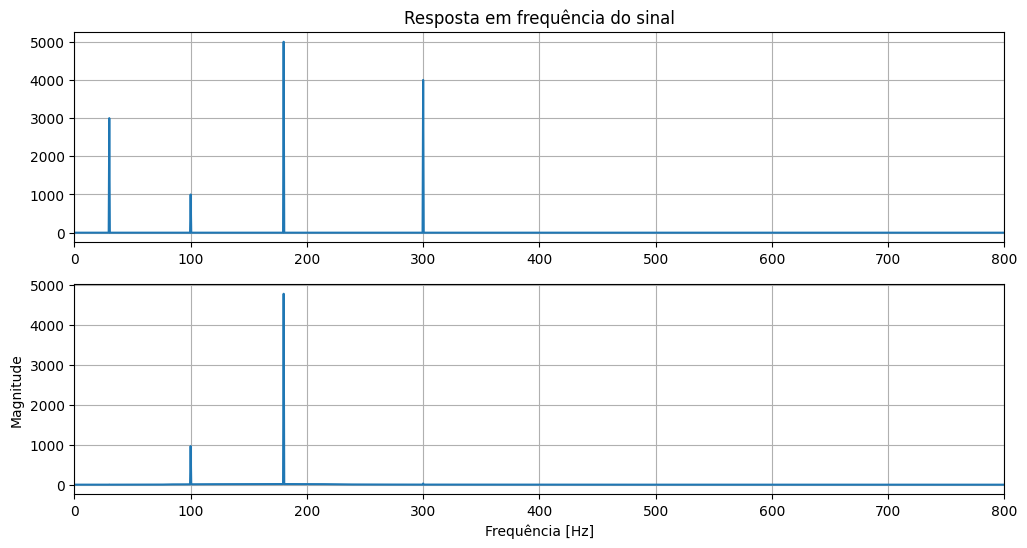

In [17]:
t = np.arange(0, 2, 1/fs)

zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, signal_data, zi=zi*signal_data[0])

#aplicar o filtro uma segunda vez.
z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])

# aplicar com filtfilt, para comparação.
y = signal.filtfilt(b, a, signal_data)


# plotar os sinais
plt.figure(1)
plt.plot(t, signal_data, 'b', alpha=0.75)
plt.plot(t, z, 'r--', t, z2, 'r', t, y, 'k')
plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice', 'filtfilt'), loc='best')
plt.grid(True)
plt.xlim(0, 0.01)
plt.show()


# Resposta em frequência (FFT)
frequencia = np.fft.fftfreq(len(signal_data), 1/fs)
espectro = np.fft.fft(signal_data)

frequencia_filtr = np.fft.fftfreq(len(z), 1/fs)
espectro_filtr = np.fft.fft(z)

# Plotar a magnitude da resposta em frequência
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencia[:len(frequencia)//2], np.abs(espectro)[:len(frequencia)//2])
plt.title('Resposta em frequência do sinal')
plt.grid(True)
plt.xlim(0, 800)
plt.subplot(2, 1, 2)
plt.plot(frequencia_filtr[:len(frequencia_filtr)//2], np.abs(espectro_filtr)[:len(frequencia_filtr)//2])
plt.xlabel('Frequência [Hz]')
plt.ylabel('Magnitude')
plt.grid(True)
plt.xlim(0, 800)
plt.show()

# Rascunhos Questão 2


In [60]:
def get_kernel(BWt, Fc, Fs=100):
    BWt = BWt/Fs
    M = 4/BWt
    M = int(M) if M % 2 == 0 else int(M+1)
    print(M)
    M = 10
    Fc_norm = Fc/Fs

    n = np.arange(M)

    h = np.sin(2* np.pi * Fc_norm * (n -( M / 2)))/(n - (M/2))  # Função Sinc
    blackman_window = np.blackman(M)  # Janela Blackman
    print("-----------------")
    print(h[1])
    print(blackman_window[1])

    h = h * blackman_window  # Aplicar janela

    centro = int(M/2)
    h[centro] = 2 * np.pi * Fc_norm
    print(h[centro])
    print("-----------------")
    print(np.sum(h))
    h = h / np.sum(h)
    return h

In [61]:
BW_PB = 44.44
Fc_PB = 20
kernel_PB = get_kernel(BW_PB, Fc_PB)
kernel_PB

10
-----------------
-0.2377641290737884
0.05086963265386543
1.2566370614359172
-----------------
2.9487463123789883


C:\Users\felip\AppData\Local\Temp\ipykernel_19748\3867428859.py:11: RuntimeWarning: invalid value encountered in divide
  h = np.sin(2* np.pi * Fc_norm * (n -( M / 2)))/(n - (M/2))  # Função Sinc


array([ 2.30543921e-34, -4.10173430e-03, -1.71427531e-02,  6.27901945e-02,
        3.06767067e-01,  4.26159774e-01,  2.03193338e-01,  2.57141296e-02,
       -3.38001495e-03,  1.11899763e-18])

In [20]:
def inversao_espectral(h):
# faz a inversão espectral
    kernel_PA = -h
    indice_centro = int (len(h)/2)
    kernel_PA[indice_centro] += 1
    return kernel_PA

In [62]:
kernel_PA = inversao_espectral(kernel_PB)
kernel_PA

array([-2.30543921e-34,  4.10173430e-03,  1.71427531e-02, -6.27901945e-02,
       -3.06767067e-01,  5.73840226e-01, -2.03193338e-01, -2.57141296e-02,
        3.38001495e-03, -1.11899763e-18])

Text(0, 0.5, 'Amplitude')

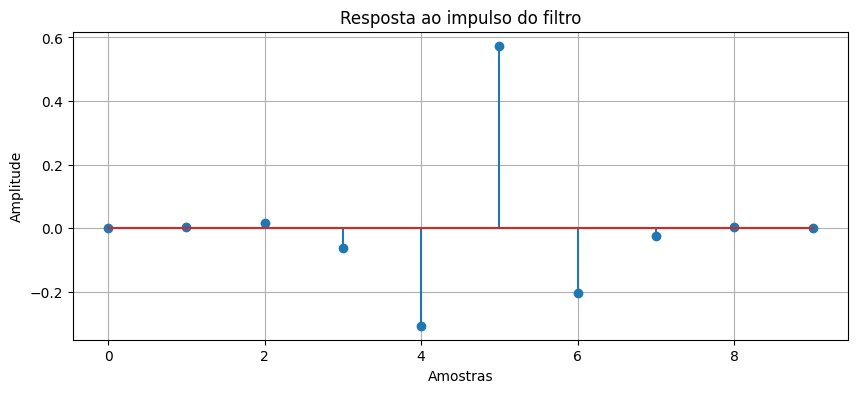

In [59]:
plt.figure(figsize=(10, 4))
plt.title("Resposta ao impulso do filtro")
plt.stem(np.arange(len(kernel_PA)), kernel_PA)
plt.grid()
plt.xlabel("Amostras")
plt.ylabel("Amplitude")

In [63]:
def cortar_transitorio(sinal,filtrado):
    dif = len(filtrado) - len(sinal)
    if dif % 2 == 0:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)]
    else:
        return filtrado[int(dif/2):len(filtrado)-int(dif/2)-1]

In [85]:
s = [0.6, -1.059017, 0.2118034, 0.05901699, -0.01180339, 3.0, -0.01180339, 0.05901699, 0.2118034, -1.059017]

sinal_filtrado = np.convolve(s, kernel_PA)

print(sinal_filtrado)
# time = np.arange(0, 2, 0.2)

sinal_filtrado_ = cortar_transitorio(s, sinal_filtrado)
print(sinal_filtrado_)
# plot_signal(s, time, fs, limite=800)
# plot_signal(sinal_filtrado_, time,fs, limite=800)

[-1.38326353e-34  2.46104058e-03  5.94184550e-03 -5.49598224e-02
 -1.13691391e-01  6.56839797e-01 -7.86199693e-01  3.55314545e-01
 -1.64620970e-01 -9.45470541e-01  1.72231967e+00 -6.65408393e-01
 -3.93960158e-02  4.44864549e-01 -6.52301061e-01  2.09938337e-01
  2.79475991e-02 -3.57949329e-03  1.18503751e-18]
[-0.11369139  0.6568398  -0.78619969  0.35531455 -0.16462097 -0.94547054
  1.72231967 -0.66540839 -0.03939602  0.44486455]


In [88]:
def real_time_convolve(entrada: list, impulso: list) -> list:
    M = len(impulso)  
    x_aux = [0] * (M - 1)  
    saida = []  

    # Itera sobre cada amostra de entrada
    for x in entrada:

        y = impulso[0] * x  

        for k in range(1, M):
            y += impulso[k] * x_aux[M - k - 1]
            
        saida.append(y)

        for k in range(M - 2):
            x_aux[k] = x_aux[k + 1]
        x_aux[M - 2] = x
    return saida

In [89]:
saida = real_time_convolve(s, kernel_PA)
saida

[np.float64(-1.3832635256608106e-34),
 np.float64(0.0024610405825976705),
 np.float64(0.005941845495786434),
 np.float64(-0.05495982237406527),
 np.float64(-0.11369139122639405),
 np.float64(0.6568397970630393),
 np.float64(-0.7861996931766424),
 np.float64(0.35531454525079853),
 np.float64(-0.16462097024576053),
 np.float64(-0.9454705405941656)]